In [15]:
import sys
sys.path.append('../')


In [16]:
import os
import cv2
import numpy as np
import time
from scipy.spatial import cKDTree

In [17]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(11, 9)

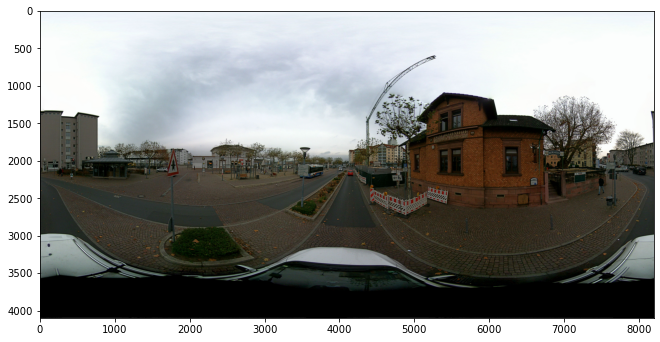

In [18]:
from faces_clustering import Equirec2Perspec as E2P

equirectangular_image = cv2.imread("C:/Users/paulo/Pictures/equirectangular.jpg", cv2.IMREAD_COLOR)

plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()

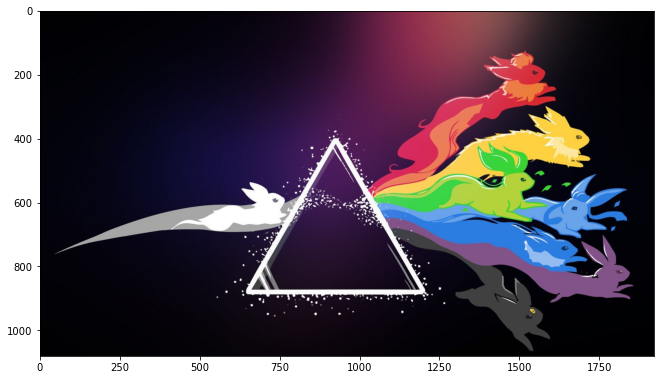

In [19]:
test = cv2.imread("C:/Users/paulo/Pictures/test.jpg")

plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

height, width = test.shape[0], test.shape[1]

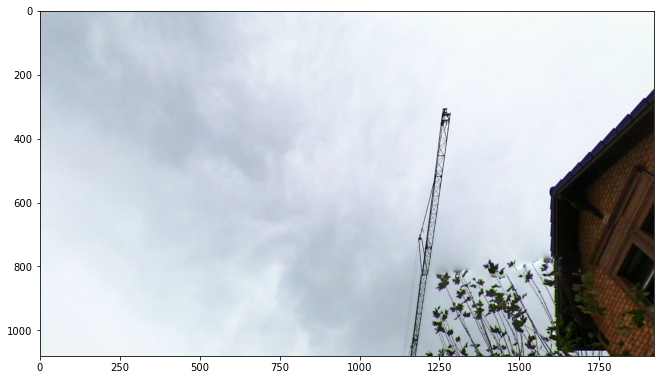

In [20]:
equirectangular = E2P.Equirectangular("C:/Users/paulo/Pictures/equirectangular.jpg")

# parameters of the projection (feel free to play with these!)
FOVw = 100

FOVh = FOVw * height/width

THETA = 60
PHI = 0
#height = 720
#width = 1080
#RADIUS = 128

rectilinear, map1, map2 = equirectangular.GetPerspective(FOVw, FOVh, PHI, THETA, width)

plt.imshow(cv2.cvtColor(rectilinear, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
h, w, _ = rectilinear.shape
H, W, _ = equirectangular_image.shape
map1_inverse = np.zeros((H, W))
map2_inverse = np.zeros((H, W))

s = time.time()

data = []
coords = []
for j in range(w):
    for i in range(h):
        data.append([map1[i, j], map2[i, j]])
        coords.append((i, j))
data = np.array(data)
tree = cKDTree(data, leafsize=16, compact_nodes=True, balanced_tree=True)
coords.append((0, 0))  # extra coords for failed neighbour search

e1 = time.time()
print("Tree creation took {:0.2f} seconds".format(e1-s))

x = np.linspace(0.0, W, num=W, endpoint=False)
y = np.linspace(0.0, H, num=H, endpoint=False)
pts = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
distances, indices = tree.query(pts, k=5, p=2, distance_upper_bound=5.0)

e2 = time.time()
print("Tree query took {:0.2f} seconds".format(e2-e1))

# TODO optimization (any suggestions? :S)
for (x, y), ds, idxs in zip(pts.astype(np.uint16), distances, indices):
    wsum_i = 0
    wsum_j = 0
    wsum = np.finfo(float).eps
    for d, idx in zip(ds, idxs):
        w = 1.0 / (d*d)
        wsum += w
        wsum_i += w*coords[idx][0]
        wsum_j += w*coords[idx][1]
    wsum_i /= wsum
    wsum_j /= wsum
    map1_inverse[y, x] = wsum_j
    map2_inverse[y, x] = wsum_i

e3 = time.time()
print("Weighted sums took {:0.2f} seconds".format(e3-e2))

Tree creation took 11.53 seconds
Tree query took 18.13 seconds
Weighted sums took 414.75 seconds


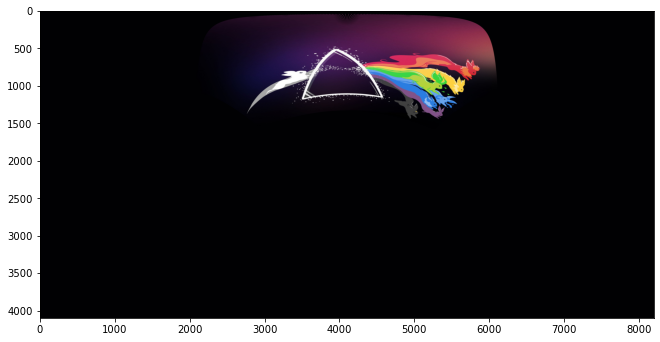

In [22]:
equirectangular_new = cv2.remap(test, map1_inverse.astype(np.float32), map2_inverse.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
plt.imshow(cv2.cvtColor(equirectangular_new, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
h, w, _ = test.shape

for j in range(w):
    for i in range(h):
        equirectangular_image[np.int(np.round(map2[i,j]))][np.int(np.round(map1[i,j]))] = test[i][j]

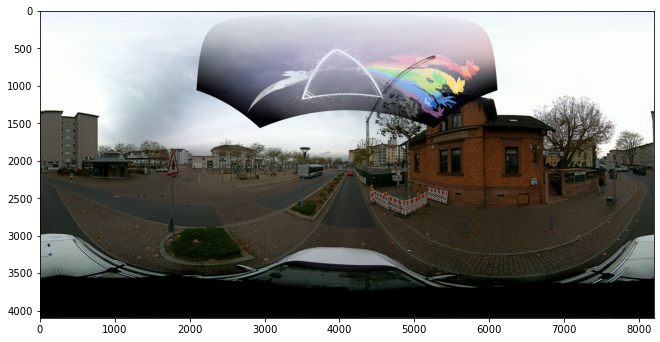

In [24]:
plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()